In [244]:
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib
from matplotlib import pyplot as plt
import tqdm
from skimage.transform import resize
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2

from torchsummary import summary

In [245]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cpu


In [246]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [247]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/"

'1566423767189[1].jpg'
'161 Proj 1 Write Up.gdoc'
'162 MT1 Review.gdoc'
'162 MT2 Cheatsheet.gdoc'
'189 Midterm Cheat Sheet.gdoc'
 1KC7709731.pdf
 2019FA12_Boxi_Fu_Chartres.mp3
'2021-2022 FAFSA on the Web Signature Page - FAFSA on the Web - Federal Student Aid - Copy.pdf'
'2021-2022 FAFSA on the Web Signature Page - FAFSA on the Web - Federal Student Aid.pdf'
'20 MIN FULL BODY WORKOUT - Beginner Version _ No Equipment I Pamela Reif.f248.webm'
'20 MIN FULL BODY WORKOUT - Beginner Version _ No Equipment I Pamela Reif.f251.webm'
'20 MIN FULL BODY WORKOUT - Beginner Version _ No Equipment I Pamela Reif.webm'
 695642F2-746C-45D3-9008-EBC523D5598E.jpeg
'ABSA Workshop PPT 2019-20.gslides'
'Academic Summary _ CalCentral (1).pdf'
'Academic Summary _ CalCentral (2).pdf'
'Academic Summary _ CalCentral.pdf'
'Adam Lucas First Draft.gdoc'
'AFA HW4.pdf'
 AFFCDAE1-A4A7-400F-B089-A84BCA6B56C5.jpeg
'Analytical Paper.gdoc'
'Analytic Paper #2.gdoc'
'Anthropocene Landscapes.gdoc'
'Architectural Approval For

In [248]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.relu = nn.ReLU()

        self.features = nn.Sequential(
            nn.Conv2d(3,12,3,1), # 3 channels
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12,16,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32 * 26 * 26, 120),
            nn.ReLU(),
            nn.Linear(120, 1) # 30 possible labels
        )
        
#         self.network_one = nn.Sequential(
#               nn.Conv2d(3, self.hidden_dim * 2, kernel_size=5, padding=2,
#                           bias=False),
#               nn.MaxPool2d(kernel_size=3, stride=2),
#               nn.BatchNorm2d(self.hidden_dim * 2),
#               nn.ReLU(),
#               nn.Conv2d(self.hidden_dim * 2, self.hidden_dim*4, kernel_size=5, padding=2, bias=False),
#               nn.MaxPool2d(kernel_size=3, stride=2),
#               nn.BatchNorm2d(self.hidden_dim*4),
#               nn.ReLU()
#         ) 
        
#         self.network_two = nn.Sequential(
#             nn.Linear(self.hidden_dim * 4 * 7 * 7, 384, bias=False),
#             nn.BatchNorm1d(384),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout),
#             nn.Linear(384, 192, bias=False),
#             nn.BatchNorm1d(192),
#             nn.ReLU(inplace=True),
#             nn.Dropout(dropout),
#             nn.Linear(192, self.num_classes)
#         )
        
    
    def forward(self, x):
        x = self.features(x)
        print(x.shape)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [249]:
cnn = ConvolutionalNeuralNetwork()
print(cnn)
cnn.to(device)
print(summary(cnn, (3, 224, 224))) # 3 x [im_width] x [im_height]

ConvolutionalNeuralNetwork(
  (relu): ReLU()
  (features): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=21632, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=1, bias=True)
  )
)
torch.Size([2, 32, 26, 26])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 222, 222]             336
              ReLU-2         [-1, 12, 222, 222]       

In [250]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# drive_dir = "fruit-and-vegetable-image-recognition"
drive_dir = "/content/drive/My Drive/fruit-and-vegetable-image-recognition/"
# Create a list with the filepaths for training and testing
# train_dir = Path('../input/fruit-and-vegetable-image-recognition/train')
train_dir = Path(drive_dir + 'train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/content/drive/My Drive/fruit-and-vegetable-image-recognition/test')
# test_dir = Path('test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

# val_dir = Path('../input/fruit-and-vegetable-image-recognition/validation')
val_dir = Path('/content/drive/My Drive/fruit-and-vegetable-image-recognition/validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
print(test_df)
val_df = proc_img(val_filepaths)

                                              Filepath        Label
0    /content/drive/My Drive/fruit-and-vegetable-im...       orange
1    /content/drive/My Drive/fruit-and-vegetable-im...  bell pepper
2    /content/drive/My Drive/fruit-and-vegetable-im...      lettuce
3    /content/drive/My Drive/fruit-and-vegetable-im...        onion
4    /content/drive/My Drive/fruit-and-vegetable-im...         corn
..                                                 ...          ...
329  /content/drive/My Drive/fruit-and-vegetable-im...     jalepeno
330  /content/drive/My Drive/fruit-and-vegetable-im...     cucumber
331  /content/drive/My Drive/fruit-and-vegetable-im...       turnip
332  /content/drive/My Drive/fruit-and-vegetable-im...    sweetcorn
333  /content/drive/My Drive/fruit-and-vegetable-im...         kiwi

[334 rows x 2 columns]


In [251]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3193

Number of different labels: 36

Labels: ['bell pepper' 'kiwi' 'apple' 'turnip' 'garlic' 'cabbage' 'peas' 'mango'
 'watermelon' 'chilli pepper' 'raddish' 'corn' 'potato' 'capsicum'
 'paprika' 'sweetcorn' 'tomato' 'pomegranate' 'lemon' 'spinach'
 'soy beans' 'cauliflower' 'pineapple' 'carrot' 'sweetpotato' 'onion'
 'eggplant' 'banana' 'ginger' 'pear' 'orange' 'beetroot' 'grapes'
 'jalepeno' 'lettuce' 'cucumber']


In [252]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

Filepath        Label
0  /content/drive/My Drive/fruit-and-vegetable-im...  bell pepper
1  /content/drive/My Drive/fruit-and-vegetable-im...         kiwi
2  /content/drive/My Drive/fruit-and-vegetable-im...        apple
3  /content/drive/My Drive/fruit-and-vegetable-im...       turnip
4  /content/drive/My Drive/fruit-and-vegetable-im...       garlic

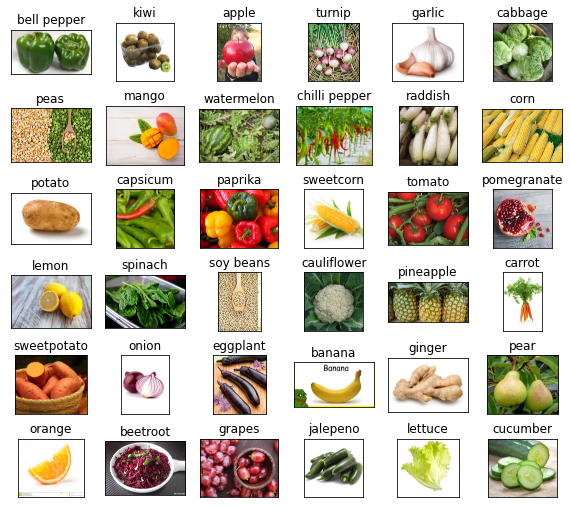

In [253]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [254]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3193 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [255]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [256]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
  2/100 [..............................] - ETA: 3:07 - loss: 3.6162 - accuracy: 0.0312

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 24/100 [======>.......................] - ETA: 2:21 - loss: 3.2209 - accuracy: 0.2102

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


100/100 [==============================] - 223s 2s/step - loss: 1.9376 - accuracy: 0.4958 - val_loss: 0.4627 - val_accuracy: 0.8653
Epoch 2/10
100/100 [==============================] - 215s 2s/step - loss: 0.7139 - accuracy: 0.7833 - val_loss: 0.2169 - val_accuracy: 0.9551
Epoch 3/10
100/100 [==============================] - 215s 2s/step - loss: 0.4212 - accuracy: 0.8710 - val_loss: 0.1872 - val_accuracy: 0.9521
Epoch 4/10
100/100 [==============================] - 215s 2s/step - loss: 0.2700 - accuracy: 0.9183 - val_loss: 0.1212 - val_accuracy: 0.9731
Epoch 5/10
100/100 [==============================] - 216s 2s/step - loss: 0.1618 - accuracy: 0.9571 - val_loss: 0.0975 - val_accuracy: 0.9641
Epoch 6/10
100/100 [==============================] - 215s 2s/step - loss: 0.1136 - accuracy: 0.9693 - val_loss: 0.0673 - val_accuracy: 0.9850
Epoch 7/10
100/100 [==============================] - 216s 2s/step - loss: 0.0833 - accuracy: 0.9787 - val_loss: 0.0655 - val_accuracy: 0.9760
Epoch 8/10

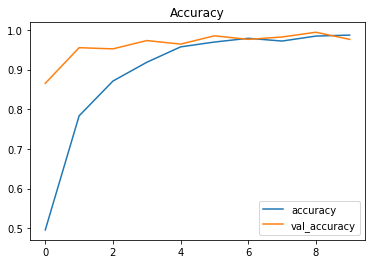

In [257]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

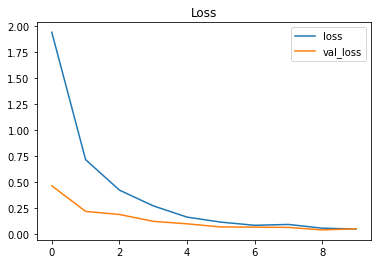

In [258]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [259]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [260]:
test_images.next()[0].shape

(32, 224, 224, 3)

In [261]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 97.60%


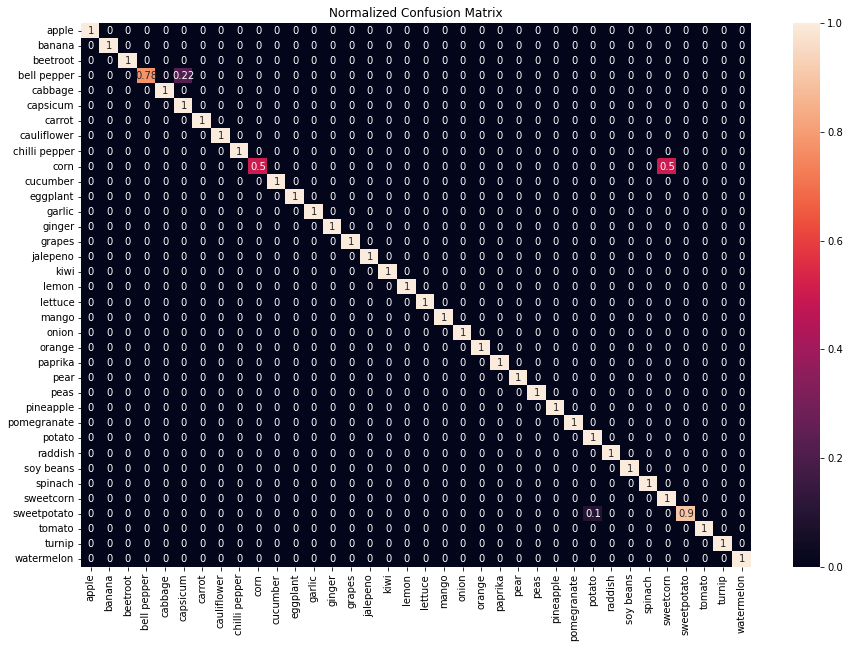

In [262]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

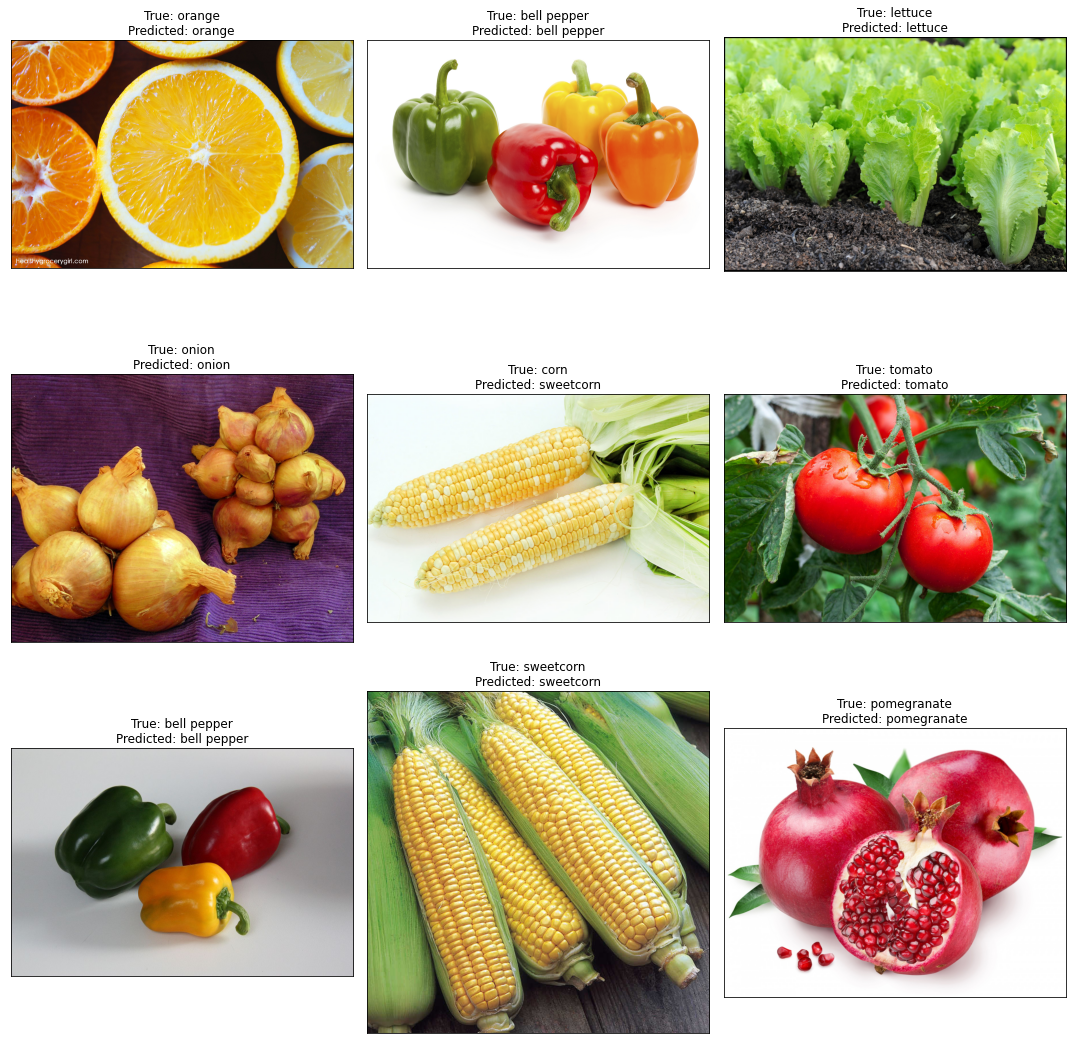

In [263]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [264]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].ativation = None

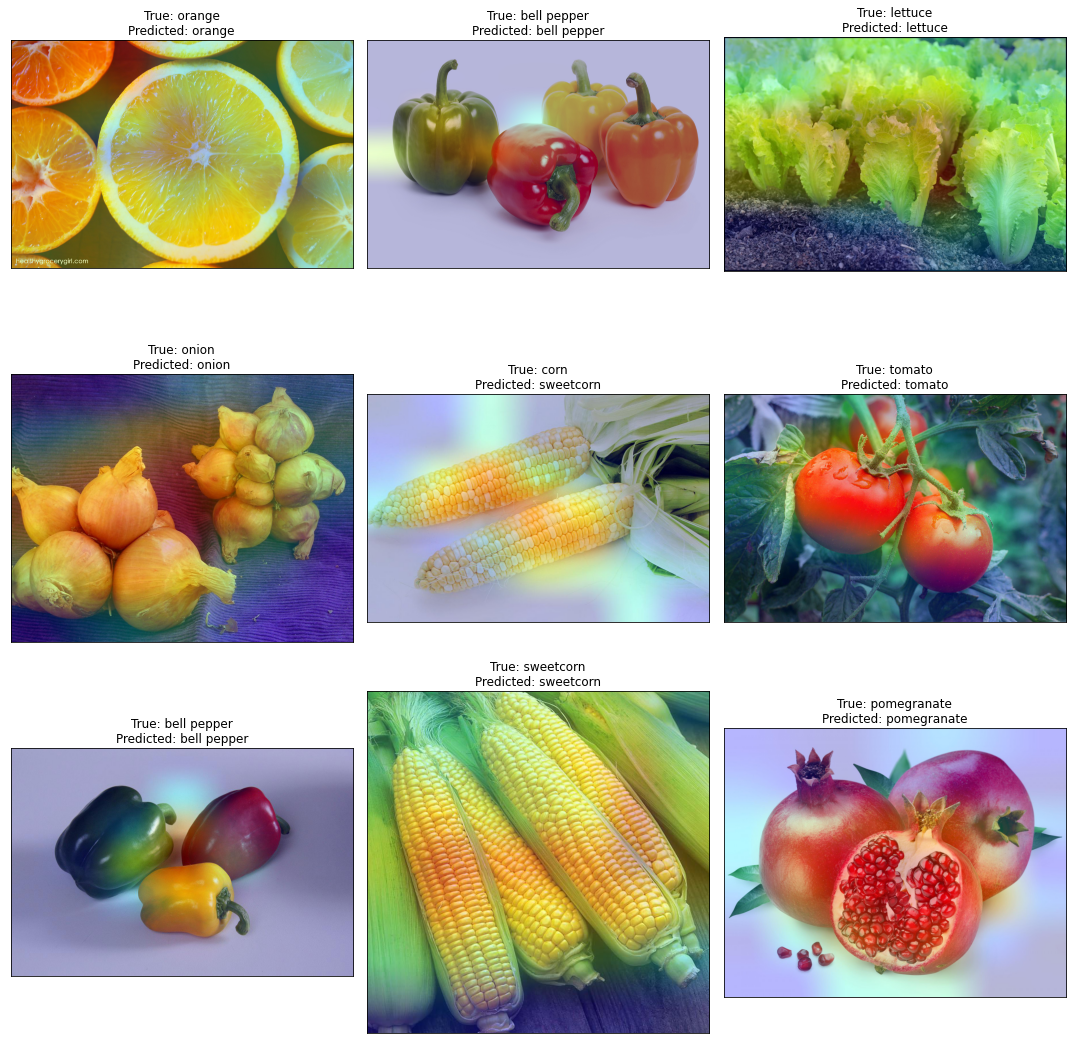

In [265]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# Reading items and the reasons why they are contradict

In [266]:
itm1 = 'potato'
itm2 = 'melon'
reason = "Ayurveda's food theory"

## Processing the data

In [267]:
from google.colab.patches import cv2_imshow

In [268]:
import os
import tensorflow as tf
from tensorflow import keras

from keras.initializers import glorot_uniform

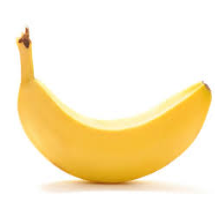

(224, 224, 3)


In [351]:
# Input Image Directory
img_dir = "/content/drive/My Drive/fruit-and-vegetable-image-recognition/image/banana.jpg"
img = cv2.imread(img_dir)
img_rs = cv2.resize(img, (224, 224))
cv2_imshow(img_rs)
print(img_rs.shape)

In [342]:
model_dir = drive_dir + "/model/fv_classification.json"
weight_dir = drive_dir + "/model/fv_weights.h5"

with open(model_dir, "r") as json_file:
    json_savedModel = json_file.read()

model_j = keras.models.model_from_json(json_savedModel)
model_j.load_weights(weight_dir)
model_j.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [343]:
model_j.input_shape

(None, 224, 224, 3)

In [344]:
img_rs_stack = np.stack([img_rs], axis=0)
img_rs_stack[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [345]:
pred = model.predict(img_rs_stack)[0]
print(pred)
pred = np.argmax(pred)
pred = labels[pred]
print(pred)

[2.7701081e-04 5.3305006e-01 6.5041419e-08 2.4737852e-07 1.2982536e-05
 5.6501667e-05 5.4033607e-04 5.1461708e-08 2.3866434e-02 4.9335002e-03
 7.8133825e-04 4.4621578e-05 3.7907241e-05 9.5763979e-03 2.2636310e-05
 2.9647318e-04 1.0398771e-03 1.6249767e-04 3.4697870e-05 2.3803327e-03
 2.0723077e-05 1.8312485e-03 1.8675721e-06 4.7773118e-03 1.8170176e-03
 1.4744487e-03 1.6999282e-06 1.1371956e-03 3.5502268e-03 2.7740768e-01
 1.3938055e-06 1.3027361e-01 3.1164059e-04 2.3996014e-04 6.1181518e-06
 3.3923196e-05]
banana


### Contradictions

In [346]:
import numpy as np
import os
import pandas as pd

from matplotlib import pyplot as plt

In [347]:
# ingredients = [pred]
ingredients = ["potato"]

cont_dir = "/content/drive/My Drive/fruit-and-vegetable-image-recognition/contradictions.txt"
# contradictions = open(cont_dir, "r")
# contradictions = contradictions.read().split('\n')
contradictions = pd.read_table(cont_dir, delimiter=";")

fruits = pd.read_table("/content/drive/My Drive/fruit-and-vegetable-image-recognition/fruit.txt").to_numpy().flatten()
vegetables = pd.read_table("/content/drive/My Drive/fruit-and-vegetable-image-recognition/vegetable.txt").to_numpy().flatten()

### Show Image

In [348]:
import numpy as np, cv2
from matplotlib import pyplot as plt

In [349]:
def show_image(itm1, itm2, reason, i):
  img1 = cv2.imread('/content/drive/My Drive/fruit-and-vegetable-image-recognition/image/' + itm1 + '.jpg')
  img2 = cv2.imread('/content/drive/My Drive/fruit-and-vegetable-image-recognition/image/' + itm2 + '.jpg')
  img3 = cv2.imread('/content/drive/My Drive/fruit-and-vegetable-image-recognition/image/white.jpg')

  width = len(reason) * 7
  height = int(width * 0.7)

  img1 = cv2.resize(img1,(width, height))
  img2 = cv2.resize(img2,(width, height))
  img3 = cv2.resize(img3,(2 * width, 50))

  vis = np.concatenate((img1, img2), axis=1)
  vis = np.concatenate((vis, img3), axis=0)

  vis = cv2.line(vis, (0, 0), (2 * width, height), (0, 0, 255), 2)
  vis = cv2.line(vis, (2 * width, 0), (0, height), (0, 0, 255), 2)
  vis = cv2.putText(vis, reason, (10,height + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

  print("showing")
  cv2.imwrite('/content/drive/My Drive/fruit-and-vegetable-image-recognition/image/out' + str(i) + '.png', vis)
  RGB_vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
  plt.imshow(RGB_vis)
  plt.title("DON'T EAT TOGETHER!!")
  plt.show()

potato;banana;they can cause freckles
showing


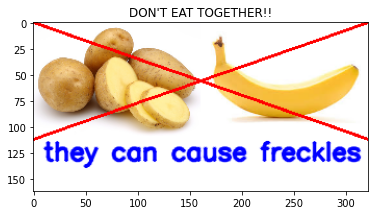

In [350]:
for ing in ingredients:
    for i in range(contradictions.shape[0]):
        itm1 = contradictions["item1"][i]
        itm2 = contradictions["item2"][i]
        if itm1 == ing or itm2 == ing or (ing in fruits and (itm1 == "fruit" or itm2 == "fruit")) or (ing in vegetables and (itm1 == "vegetable" or itm2 == "vegetable")):
            r = contradictions["reason"][i]
            print(itm1 + ";" + itm2 + ";" + r)

            show_image(itm1, itm2, r, i)
            break

    print("\n")